In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jax
import jax.numpy as jnp
import equinox  as eqx
import os
import json
import sys
import desisky
from desisky.data import SkySpecVAC

In [2]:
class VAE(eqx.Module):
    in_channels: int
    latent_dim: int
    common_fc: eqx.nn.Sequential
    mean_fc: eqx.nn.Sequential
    log_var_fc: eqx.nn.Sequential
    decoder_fcs: eqx.nn.Sequential
    
    def __init__(self, 
                 key,
                 in_channels: int,
                 latent_dim: int):
        
        keys = jax.random.split(key, 50)
        self.in_channels = in_channels
        self.latent_dim = latent_dim
        self.common_fc = eqx.nn.Sequential([
            eqx.nn.Linear(in_channels, 1000, key=keys[0]),
            eqx.nn.Lambda(jax.nn.relu),
            eqx.nn.Linear(1000, 800, key=keys[1]),
            eqx.nn.Lambda(jax.nn.relu),
            eqx.nn.Linear(800, 600, key=keys[2]),
            eqx.nn.Lambda(jax.nn.relu),
            eqx.nn.Linear(600, 500, key=keys[3]),
            eqx.nn.Lambda(jax.nn.relu),
            eqx.nn.Linear(500, 300, key=keys[4]),
            eqx.nn.Lambda(jax.nn.relu),
            eqx.nn.Linear(300, self.latent_dim, key=keys[5])
        ])
        # The mean & sigma calculations are being done in
        # the latent space, so these should have the same 
        # dimensions as the output of the encoder & the input
        # of the decoder
        self.mean_fc = eqx.nn.Sequential([
            eqx.nn.Linear(self.latent_dim, self.latent_dim, key=keys[6]),
            eqx.nn.Lambda(jax.nn.relu),
            eqx.nn.Linear(self.latent_dim, self.latent_dim, key=keys[7])
        ])
        self.log_var_fc = eqx.nn.Sequential([
            eqx.nn.Linear(self.latent_dim, self.latent_dim, key=keys[8]),
            eqx.nn.Lambda(jax.nn.relu),
            eqx.nn.Linear(self.latent_dim, self.latent_dim, key=keys[9])
        ])

        self.decoder_fcs = eqx.nn.Sequential([
            eqx.nn.Linear(self.latent_dim, 300, key=keys[10]),
            eqx.nn.Lambda(jax.nn.relu),
            eqx.nn.Linear(300, 500, key=keys[11]),
            eqx.nn.Lambda(jax.nn.relu),
            eqx.nn.Linear(500, 600, key=keys[12]),
            eqx.nn.Lambda(jax.nn.relu),
            eqx.nn.Linear(600, 800, key=keys[13]),
            eqx.nn.Lambda(jax.nn.relu),
            eqx.nn.Linear(800, 1000, key=keys[14]),
            eqx.nn.Lambda(jax.nn.relu),
            eqx.nn.Linear(1000, in_channels, key=keys[15])
        ])

    def __call__(self, x, key):
        # x.shape = (B, L)
        ## Encode the input
        mean, logvar = jax.vmap(self.encode)(x)
        ## Sample from the latent space
        z = self.sample(mean, logvar, key)
        ## Decode the latent representation
        out = jax.vmap(self.decode)(z)
        return {'mean': mean,
                'logvar': logvar,
                'output': out,
                'latent': z}

    def encode(self, x):
        out = self.common_fc(x)
        mean = self.mean_fc(out)
        log_var = self.log_var_fc(out)
        return mean, log_var
    
    def sample(self, mean, log_var, key):
        std = jnp.exp(0.5 * log_var)
        z = jax.random.normal(key, std.shape)
        z = z * std + mean
        return z
    
    def decode(self, z):
        out = self.decoder_fcs(z)
        return out
    

In [3]:
def get_base_dir() -> str:
    """
    Determine base directory of the project. This function checks if the
    code is running w/in Jupyter notebooks or as standalone scripts.

    Returns:
        str: Absolute path of the base dir.
    """
    # Check if running in a Jupyter notebook
    if 'ipykernel' in sys.modules:
        # Assuming notebooks are in the 'notebooks' folder, move one folder up to get base dir.
        return os.path.abspath(os.path.join(os.getcwd(), ".."))
    else:
        # Get the dir of current script and move one folder up to base dir.
        return os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))

def make_VAE(*, 
             in_channels: int,
             latent_dim: int) -> 'Any':
    """
    Creates VAE to be saved
    """
    return VAE(key=jax.random.PRNGKey(0),
               in_channels=in_channels,
               latent_dim=latent_dim)

def load_vae(filename: str, project_name: str) -> "Any":
    """
    Load a model along with its hyperparameters from a specified file.

    Args:
        filename (str): The name of the file from which to load the model.

    Returns:
        Any: The deserialized model instance.
    """
    # Fetch base directory path
    base_dir = get_base_dir()

    # Determine directory where the model is saved
    save_directory = os.path.join(base_dir, 'saved_models/' + str(project_name))

    # Create the directory if it doesn't exist
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # Construct the full path from where to load the model
    full_path = os.path.join(save_directory, filename+".eqx")

    # Open the file in binary read mode and load the hyperparameters and model
    with open(full_path, "rb") as f:
        hyperparams = json.loads(f.readline().decode())
        model = make_VAE(**hyperparams)
        return eqx.tree_deserialise_leaves(f, model)

In [4]:
save_directory = os.path.join('/home/mdowicz/desisky/src/desisky/weights/')

if not os.path.exists(save_directory):
    os.makedirs(save_directory)

full_path = os.path.join(save_directory, 'vae_weights.eqx')

with open(full_path, "rb") as f:
    hyperparams = json.loads(f.readline().decode())
    model = make_VAE(**hyperparams)
    vae = eqx.tree_deserialise_leaves(f, model)

In [5]:
vac = SkySpecVAC(version='v1.0', download=True)

wavelength, flux, metadata = vac.load()


In [6]:

# Encode the input
mean, logvar = jax.vmap(vae.encode)(flux.squeeze())
# Sample from latent space
latents = vae.sample(mean, logvar, jax.random.PRNGKey(2))
# Decode the latent representation
decoded = jax.vmap(vae.decode)(latents)

# Do all of the above at once
out = vae(flux.squeeze(), jax.random.PRNGKey(1))

print(mean.shape, logvar.shape)
print(latents.shape)
print(decoded.shape)
print()
print(out.keys())

(9176, 8) (9176, 8)
(9176, 8)
(9176, 7781)

dict_keys(['mean', 'logvar', 'output', 'latent'])


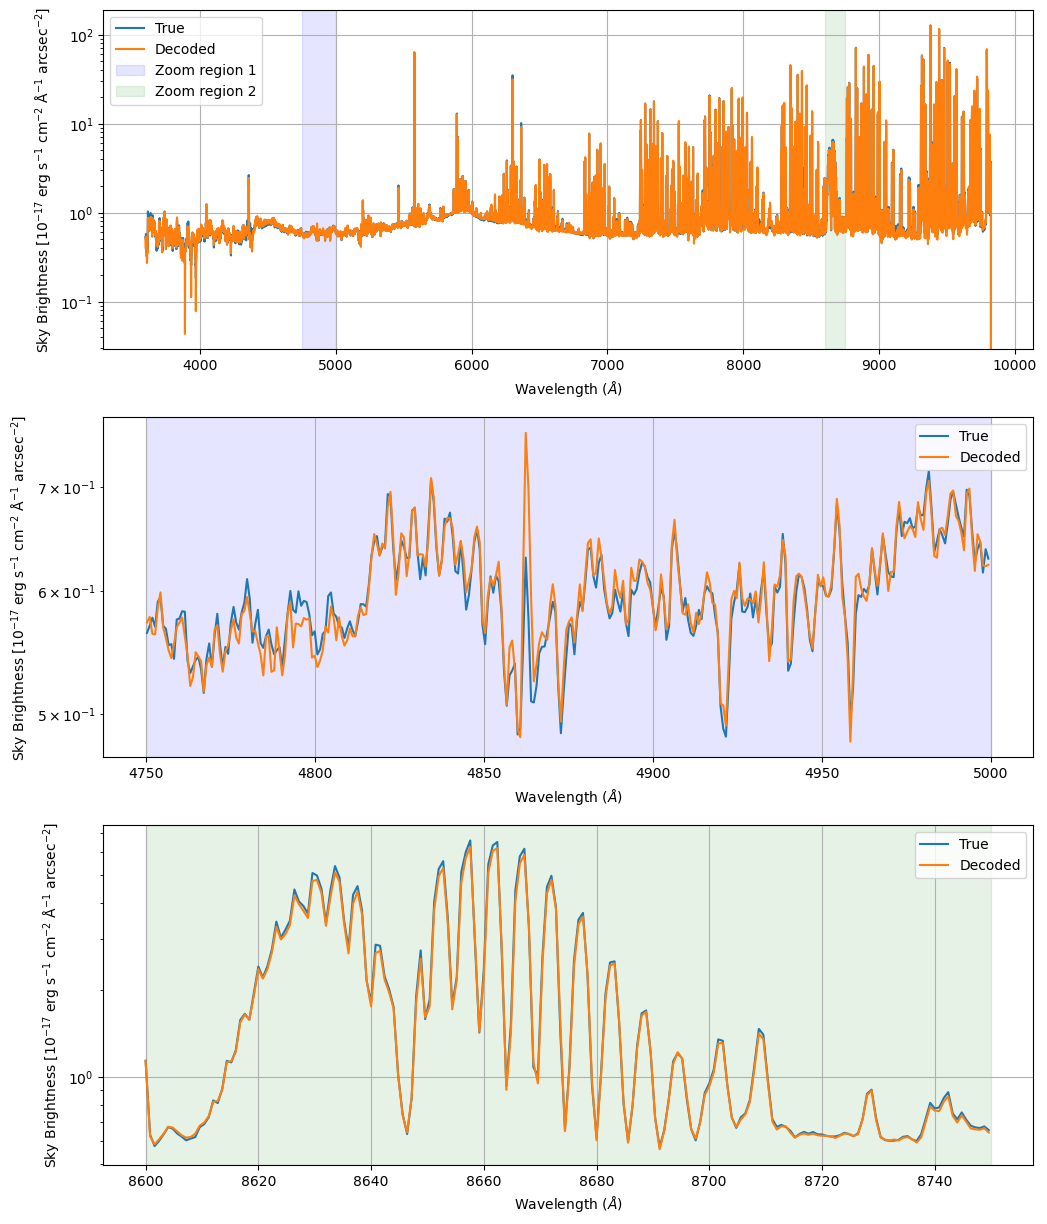

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(12, 15))
axs[0].plot(wavelength, flux[0], label='True')
axs[0].plot(wavelength, decoded[0], label='Decoded')
axs[0].axvspan(4750, 5000, color='blue', alpha=0.1, label='Zoom region 1')
axs[0].axvspan(8600, 8750, color='green', alpha=0.1, label='Zoom region 2')
axs[0].set_yscale('log')
axs[0].set_xlabel('Wavelength ($\\AA$)')
axs[0].set_ylabel('Sky Brightness [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$ arcsec$^{-2}$]')
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles[:2] + handles[-2:], labels[:2] + labels[-2:])  # True, Decoded, regions
axs[0].grid()

i0 = np.searchsorted(wavelength, 4750)
i1 = np.searchsorted(wavelength, 5000)
axs[1].plot(wavelength[i0:i1], flux[0,i0:i1], label='True')
axs[1].plot(wavelength[i0:i1], decoded[0,i0:i1], label='Decoded')
axs[1].axvspan(4750, 5000, color='blue', alpha=0.1)
axs[1].set_yscale('log')
axs[1].set_xlabel('Wavelength ($\\AA$)')
axs[1].set_ylabel('Sky Brightness [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$ arcsec$^{-2}$]')
axs[1].legend()
axs[1].grid()

i0 = np.searchsorted(wavelength, 8600)
i1 = np.searchsorted(wavelength, 8750)
axs[2].plot(wavelength[i0:i1], flux[0,i0:i1], label='True')
axs[2].plot(wavelength[i0:i1], decoded[0,i0:i1], label='Decoded')
axs[2].axvspan(8600, 8750, color='green', alpha=0.1)
axs[2].set_yscale('log')
axs[2].set_xlabel('Wavelength ($\\AA$)')
axs[2].set_ylabel('Sky Brightness [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$ arcsec$^{-2}$]')
axs[2].legend()
axs[2].grid()
plt.show()

/tmp/ipykernel_3819625/1138439616.py:190: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.3)


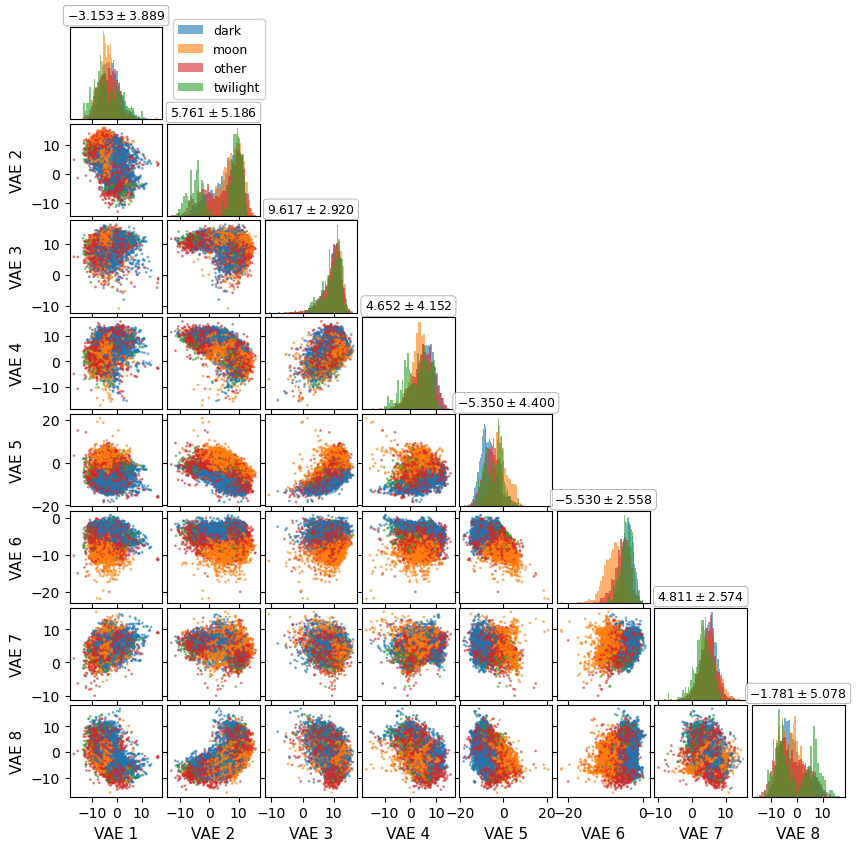

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.colors import ListedColormap

def corner_plot(samples, labels=None, bins=40, figsize=10, max_dims=None,
                plot_type='contour', show_stats=True, show_lines=True, 
                colors=None, point_kwargs=None):
    """
    Corner plot (lower triangle + 1D marginals on the diagonal).

    Parameters
    ----------
    samples : (N, D) array
        Sample array with N samples and D dimensions
    labels : list[str] or None
        Labels for each dimension (default: "VAE 1", "VAE 2", etc.)
    bins : int
        Number of bins for 1D histogram
    figsize : float
        Figure size (square)
    max_dims : int or None
        If set, only plot the first `max_dims` dimensions
    plot_type : str
        Either 'contour' for KDE contours or 'scatter' for scatter points
    show_stats : bool
        If True, annotate mean ± 1σ values above diagonal histograms
    show_lines : bool
        If True, show mean (solid) and ± 1σ (dashed) lines on diagonal histograms
    colors : array-like or None
        Optional color labels for each sample (e.g., sky conditions).
        Can be categorical (strings) or numerical values.
    point_kwargs : dict or None
        Keyword arguments for scatter plot (only used if plot_type='scatter')
    """
    samples = np.asarray(samples)
    N, D = samples.shape

    if max_dims is not None and max_dims < D:
        D = max_dims
        samples = samples[:, :D]

    # Default labels: VAE 1, VAE 2, etc.
    if labels is None:
        labels = [f"VAE {i+1}" for i in range(D)]
    else:
        if len(labels) < D:
            labels = list(labels) + [f"VAE {i+1}" for i in range(len(labels), D)]
        else:
            labels = list(labels[:D])

    # Compute statistics
    means = samples.mean(axis=0)
    stds = samples.std(axis=0, ddof=1)

    # Handle colors for categorical data
    color_map = None
    categorical_colors = None
    unique_categories = None
    if colors is not None:
        colors = np.asarray(colors)
        # Check if categorical (strings or mixed types)
        if colors.dtype.kind in ['U', 'S', 'O']:  # Unicode, byte string, or object
            unique_categories = np.unique(colors)
            # Define color scheme for sky conditions
            sky_color_scheme = {
                'dark': '#1f77b4',      # blue
                'moon': '#ff7f0e',      # orange
                'twilight': '#2ca02c', # green
                'other': '#d62728'      # red
            }
            # Create color map
            categorical_colors = [sky_color_scheme.get(cat, '#7f7f7f') for cat in colors]
            color_map = {cat: sky_color_scheme.get(cat, '#7f7f7f') for cat in unique_categories}

    # Create figure with reduced spacing
    fig, axes = plt.subplots(D, D, figsize=(figsize, figsize),
                             gridspec_kw={'hspace': 0.05, 'wspace': 0.05})

    # Handle point kwargs
    if point_kwargs is None:
        point_kwargs = {'s': 1, 'alpha': 0.5, 'rasterized': True}

    # Store legend handles for later
    legend_handles = []

    for i in range(D):
        for j in range(D):
            ax = axes[i, j]

            if i == j:
                # 1D marginal histogram
                if categorical_colors is not None:
                    # Stacked histogram by category
                    for cat in unique_categories:
                        mask = colors == cat
                        h = ax.hist(samples[mask, i], bins=bins, density=True, 
                               alpha=0.6, color=color_map[cat], label=cat)
                        # Store handles from first panel for legend
                        if i == 0:
                            legend_handles.append(plt.Rectangle((0,0),1,1, fc=color_map[cat], alpha=0.6))
                else:
                    ax.hist(samples[:, i], bins=bins, density=True, alpha=0.7, color='steelblue')

                # Show mean ± 1σ lines
                if show_lines:
                    ax.axvline(means[i], color='red', linestyle='-', linewidth=1.5, label='Mean')
                    ax.axvline(means[i] - stds[i], color='red', linestyle='--', linewidth=1)
                    ax.axvline(means[i] + stds[i], color='red', linestyle='--', linewidth=1)

                # Annotate with mean ± std values ABOVE the panel
                if show_stats:
                    stats_text = f'${means[i]:.3f} \\pm {stds[i]:.3f}$'
                    ax.text(0.5, 1.05, stats_text, 
                           transform=ax.transAxes,
                           ha='center', va='bottom',
                           fontsize=9,
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray', linewidth=0.5))

                # X-axis: show ticks on bottom row only
                if i == D - 1:
                    ax.set_xlabel(labels[i], fontsize=11)
                else:
                    ax.set_xticklabels([])

                # Y-axis: remove tick labels (density values not important)
                ax.set_yticklabels([])
                ax.tick_params(axis='y', which='both', left=False)

            elif i > j:
                # Lower triangle: 2D density
                x = samples[:, j]
                y = samples[:, i]

                if plot_type == 'contour':
                    if categorical_colors is not None:
                        # Plot contours for each category
                        for cat in unique_categories:
                            mask = colors == cat
                            if np.sum(mask) > 10:  # Need enough points for KDE
                                x_cat = x[mask]
                                y_cat = y[mask]
                                kde = gaussian_kde(np.vstack([x_cat, y_cat]))
                                xx, yy = np.meshgrid(
                                    np.linspace(x.min(), x.max(), 100),
                                    np.linspace(y.min(), y.max(), 100)
                                )
                                zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
                                ax.contour(xx, yy, zz, levels=3, colors=[color_map[cat]], alpha=0.7)
                    else:
                        # KDE contours
                        kde = gaussian_kde(np.vstack([x, y]))
                        xx, yy = np.meshgrid(
                            np.linspace(x.min(), x.max(), 120),
                            np.linspace(y.min(), y.max(), 120)
                        )
                        zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
                        ax.contour(xx, yy, zz, levels=5, colors='steelblue')
                else:
                    # Scatter plot
                    if categorical_colors is not None:
                        scatter_kwargs = point_kwargs.copy()
                        scatter_kwargs.pop('color', None)  # Remove color if present
                        ax.scatter(x, y, c=categorical_colors, **scatter_kwargs)
                    else:
                        ax.scatter(x, y, **point_kwargs)

                # Left column gets y-labels
                if j == 0:
                    ax.set_ylabel(labels[i], fontsize=11)
                else:
                    ax.set_yticklabels([])

                # Bottom row gets x-labels
                if i == D - 1:
                    ax.set_xlabel(labels[j], fontsize=11)
                else:
                    ax.set_xticklabels([])

            else:
                # Upper triangle: off
                ax.axis("off")

    # Add legend to the right of the first diagonal panel
    if categorical_colors is not None and len(legend_handles) > 0:
        axes[0, 0].legend(legend_handles, unique_categories, 
                         loc='center left', bbox_to_anchor=(1.05, 0.65),
                         fontsize=9, framealpha=0.9)

    plt.tight_layout(pad=0.3)
    return fig

# Helper function to classify sky conditions
def classify_sky(meta):
    """
    Classify sky conditions based on metadata.
    
    Parameters
    ----------
    meta : DataFrame
        Metadata with columns: SUNALT, MOONALT, MOONFRAC, MOONSEP, SUNSEP
    
    Returns
    -------
    conditions : array of str
        Sky condition for each observation: 'dark', 'moon', 'twilight', or 'other'
    """
    conditions = []
    for i in range(len(meta)):
        sunalt = meta.iloc[i]['SUNALT']
        moonalt = meta.iloc[i]['MOONALT']
        moonfrac = meta.iloc[i]['MOONFRAC']
        moonsep = meta.iloc[i]['MOONSEP']
        sunsep = meta.iloc[i]['SUNSEP']

        if (sunalt > -20) and (moonalt <= -5) and (sunsep <= 110):
            conditions.append("twilight")
        elif (moonalt > 5) and (moonfrac > 0.5) and (moonsep <= 90) and (sunalt < -20):
            conditions.append("moon")
        elif (moonalt < -5) and (sunalt < -20):
            conditions.append("dark")
        else:
            conditions.append("other")
    return np.array(conditions)

# Example without color coding
# fig = corner_plot(latents, max_dims=8, plot_type='contour', show_stats=True, show_lines=True)
# plt.show()

# Example WITH color coding by sky condition
sky_conditions = classify_sky(metadata)
fig = corner_plot(latents, max_dims=8, plot_type='scatter', 
                 show_stats=True, show_lines=False, colors=sky_conditions)
plt.show()

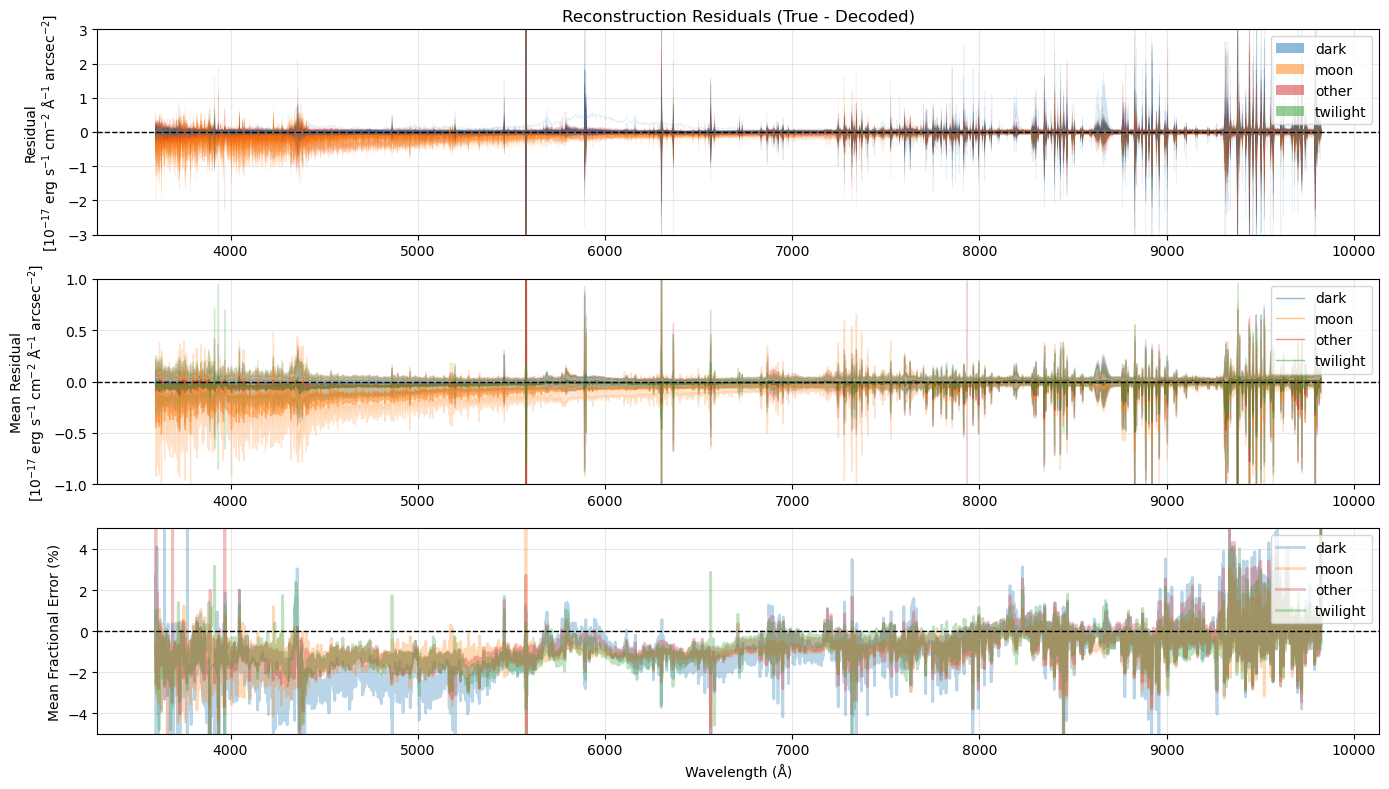

In [9]:
# ============================================================================
# 1. Reconstruction Residuals (Wavelength-dependent errors)
# ============================================================================

def plot_reconstruction_residuals(wavelength, flux, decoded, sky_conditions, 
                                   n_samples=100, figsize=(14, 8)):
    """
    Plot reconstruction residuals to show where the VAE struggles.
    
    Parameters
    ----------
    wavelength : array
        Wavelength array
    flux : array
        True flux values (N, wavelength)
    decoded : array
        Reconstructed flux values (N, wavelength)
    sky_conditions : array
        Sky condition labels for each sample
    n_samples : int
        Number of random samples to plot
    """
    # Calculate residuals
    residuals = flux - decoded
    
    # Color scheme
    sky_color_scheme = {
        'dark': '#1f77b4',
        'moon': '#ff7f0e',
        'twilight': '#2ca02c',
        'other': '#d62728'
    }
    
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    
    # Panel 1: Individual residuals colored by sky condition
    indices = np.random.choice(len(flux), size=min(n_samples, len(flux)), replace=False)
    for idx in indices:
        color = sky_color_scheme.get(sky_conditions[idx], '#7f7f7f')
        axes[0].plot(wavelength, residuals[idx], alpha=0.1, color=color, linewidth=0.5)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=sky_color_scheme[cat], alpha=0.5, label=cat) 
                      for cat in np.unique(sky_conditions)]
    axes[0].set_ylim(-3, 3)
    axes[0].legend(handles=legend_elements, loc='upper right')
    axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[0].set_ylabel('Residual\n[$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$ arcsec$^{-2}$]')
    axes[0].set_title('Reconstruction Residuals (True - Decoded)')
    axes[0].grid(alpha=0.3)
    
    # Panel 2: Mean and std of residuals by condition
    for condition in np.unique(sky_conditions):
        mask = sky_conditions == condition
        mean_residual = np.mean(residuals[mask], axis=0)
        std_residual = np.std(residuals[mask], axis=0)
        
        color = sky_color_scheme.get(condition, '#7f7f7f')
        axes[1].plot(wavelength, mean_residual, label=condition, alpha=0.5, color=color, linewidth=1)
        axes[1].fill_between(wavelength, 
                             mean_residual - std_residual,
                             mean_residual + std_residual,
                             alpha=0.2, color=color)
    axes[1].set_ylim(-1, 1)
    axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[1].set_ylabel('Mean Residual\n[$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$ arcsec$^{-2}$]')
    axes[1].legend(loc='upper right')
    axes[1].grid(alpha=0.3)
    
    # Panel 3: Fractional error (residual / true)
    fractional_error = residuals / (flux + 1e-10)  # Add small value to avoid division by zero
    for condition in np.unique(sky_conditions):
        mask = sky_conditions == condition
        mean_frac_error = np.mean(fractional_error[mask], axis=0)
        
        color = sky_color_scheme.get(condition, '#7f7f7f')
        axes[2].plot(wavelength, mean_frac_error * 100, label=condition, alpha=0.3, color=color, linewidth=2)
    
    axes[2].set_ylim(-5, 5)
    axes[2].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[2].set_xlabel('Wavelength (Å)')
    axes[2].set_ylabel('Mean Fractional Error (%)')
    axes[2].legend(loc='upper right')
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    return fig

# Generate the plot
fig = plot_reconstruction_residuals(wavelength, flux.squeeze(), decoded, sky_conditions, n_samples=200)
plt.show()

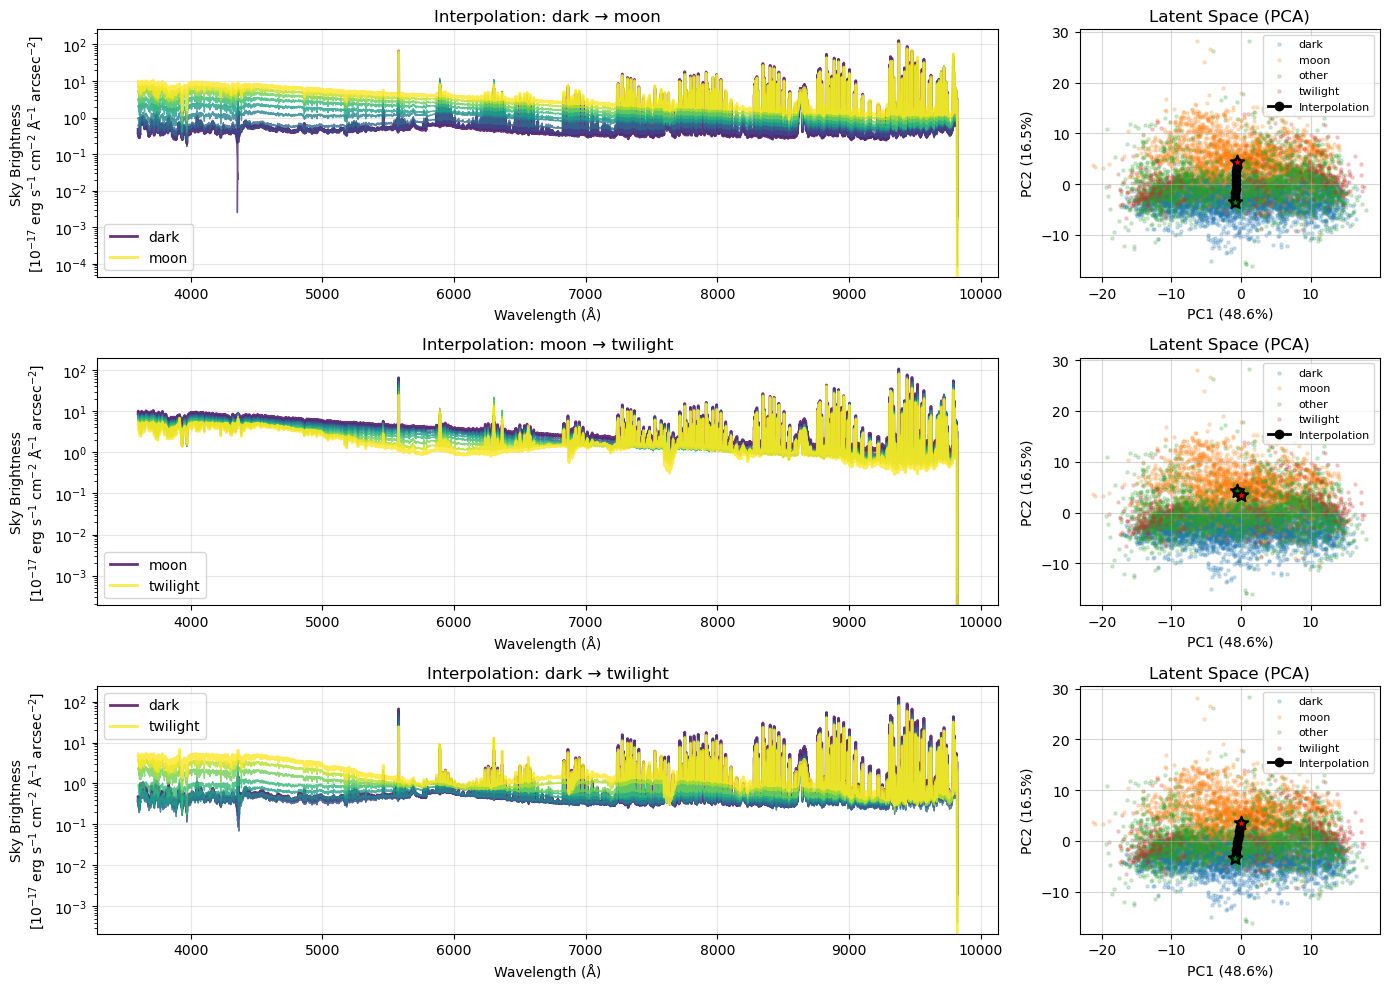

In [10]:
# ============================================================================
# 4. Latent Space Interpolation
# ============================================================================

def plot_latent_interpolation(vae, latents, sky_conditions, wavelength, 
                              n_steps=7, figsize=(14, 10)):
    """
    Interpolate between different sky conditions in latent space and decode.
    
    Parameters
    ----------
    vae : VAE model
        The trained VAE
    latents : array
        Latent representations (N, latent_dim)
    sky_conditions : array
        Sky condition labels
    wavelength : array
        Wavelength array
    n_steps : int
        Number of interpolation steps
    """
    # Find representative examples of each condition (closest to mean)
    representatives = {}
    for condition in ['dark', 'moon', 'twilight']:
        if condition in sky_conditions:
            mask = sky_conditions == condition
            if np.sum(mask) > 0:
                cond_latents = latents[mask]
                mean_latent = np.mean(cond_latents, axis=0)
                # Find closest sample to mean
                distances = np.sum((cond_latents - mean_latent)**2, axis=1)
                closest_idx = np.argmin(distances)
                representatives[condition] = cond_latents[closest_idx]
    
    # Create interpolations
    interpolations = [
        ('dark', 'moon'),
        ('moon', 'twilight'),
        ('dark', 'twilight')
    ]
    
    n_interp = len([interp for interp in interpolations if interp[0] in representatives and interp[1] in representatives])
    fig, axes = plt.subplots(n_interp, 2, figsize=figsize, 
                            gridspec_kw={'width_ratios': [3, 1]})
    
    if n_interp == 1:
        axes = axes.reshape(1, -1)
    
    plot_idx = 0
    for start_cond, end_cond in interpolations:
        if start_cond not in representatives or end_cond not in representatives:
            continue
            
        start_latent = representatives[start_cond]
        end_latent = representatives[end_cond]
        
        # Create interpolation
        alphas = np.linspace(0, 1, n_steps)
        interpolated_latents = np.array([
            (1 - alpha) * start_latent + alpha * end_latent 
            for alpha in alphas
        ])
        
        # Decode interpolated latents
        decoded_spectra = jax.vmap(vae.decode)(interpolated_latents)
        
        # Color scheme for interpolation
        cmap = plt.cm.viridis
        
        # Panel 1: Decoded spectra
        for i, (alpha, spectrum) in enumerate(zip(alphas, decoded_spectra)):
            color = cmap(alpha)
            label = f'{start_cond}' if i == 0 else (f'{end_cond}' if i == n_steps-1 else None)
            axes[plot_idx, 0].plot(wavelength, spectrum, color=color, alpha=0.8, 
                                  linewidth=2 if i in [0, n_steps-1] else 1,
                                  label=label)
        
        axes[plot_idx, 0].set_yscale('log')
        axes[plot_idx, 0].set_xlabel('Wavelength (Å)')
        axes[plot_idx, 0].set_ylabel('Sky Brightness\n[$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$ arcsec$^{-2}$]')
        axes[plot_idx, 0].set_title(f'Interpolation: {start_cond} → {end_cond}')
        axes[plot_idx, 0].legend()
        axes[plot_idx, 0].grid(alpha=0.3)
        
        # Panel 2: Latent space trajectory
        # Show first 3 principal components
        from sklearn.decomposition import PCA
        pca = PCA(n_components=min(3, latents.shape[1]))
        all_latents_pca = pca.fit_transform(latents)
        interp_pca = pca.transform(interpolated_latents)
        
        # Plot all samples faintly
        for condition in np.unique(sky_conditions):
            mask = sky_conditions == condition
            axes[plot_idx, 1].scatter(all_latents_pca[mask, 0], 
                                     all_latents_pca[mask, 1],
                                     alpha=0.2, s=5, label=condition)
        
        # Plot interpolation path
        axes[plot_idx, 1].plot(interp_pca[:, 0], interp_pca[:, 1], 
                              'k-', linewidth=2, marker='o', markersize=6,
                              label='Interpolation')
        axes[plot_idx, 1].scatter(interp_pca[0, 0], interp_pca[0, 1], 
                                 c='green', s=100, marker='*', 
                                 edgecolors='black', linewidths=1.5, zorder=10)
        axes[plot_idx, 1].scatter(interp_pca[-1, 0], interp_pca[-1, 1], 
                                 c='red', s=100, marker='*',
                                 edgecolors='black', linewidths=1.5, zorder=10)
        
        axes[plot_idx, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        axes[plot_idx, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        axes[plot_idx, 1].set_title('Latent Space (PCA)')
        axes[plot_idx, 1].legend(fontsize=8)
        axes[plot_idx, 1].grid(alpha=0.5)
        
        plot_idx += 1
    
    plt.tight_layout()
    return fig

# Generate the plot
fig = plot_latent_interpolation(vae, latents, sky_conditions, wavelength, n_steps=10)
plt.show()

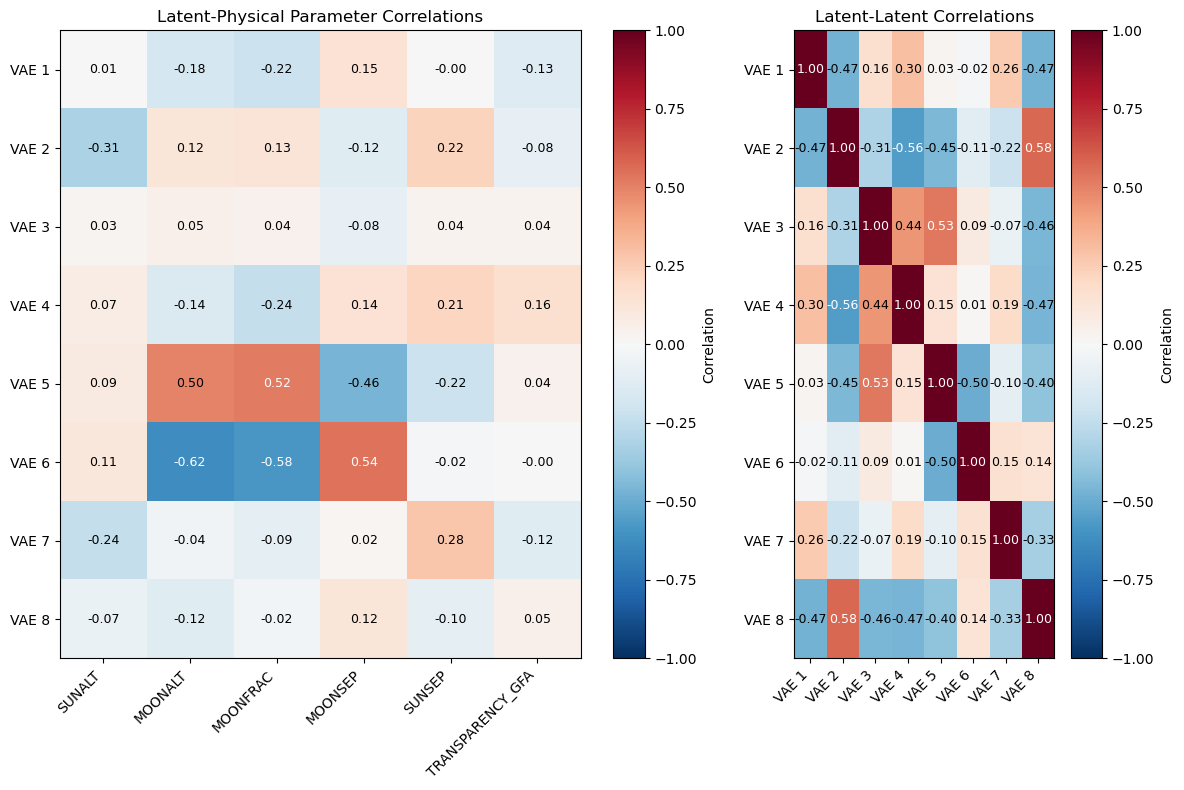

Reconstruction Error Summary by Sky Condition:

DARK:
  Count: 4177
  MSE:   0.0176 ± 0.0523
         Median: 0.0095 | 95th: 0.0405 | 99th: 0.1414
  MAE:   0.0374 ± 0.0164
         Median: 0.0349 | 95th: 0.0552 | 99th: 0.0910

MOON:
  Count: 2290
  MSE:   0.0526 ± 0.1068
         Median: 0.0303 | 95th: 0.1314 | 99th: 0.4627
  MAE:   0.0988 ± 0.0644
         Median: 0.0823 | 95th: 0.2055 | 99th: 0.3085

OTHER:
  Count: 2373
  MSE:   0.0260 ± 0.0905
         Median: 0.0124 | 95th: 0.0624 | 99th: 0.2494
  MAE:   0.0554 ± 0.0385
         Median: 0.0450 | 95th: 0.1211 | 99th: 0.2110

TWILIGHT:
  Count: 336
  MSE:   0.0201 ± 0.0424
         Median: 0.0129 | 95th: 0.0427 | 99th: 0.0857
  MAE:   0.0596 ± 0.0321
         Median: 0.0504 | 95th: 0.1229 | 99th: 0.1790


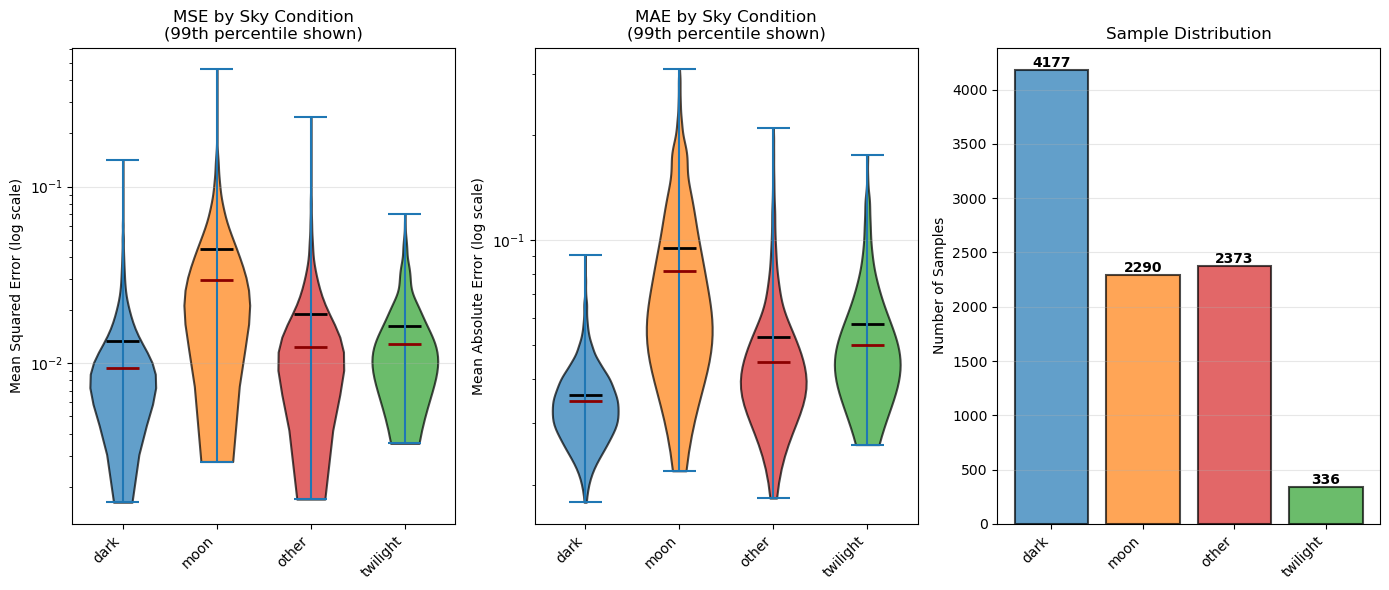

In [11]:
# ============================================================================
# 2. Latent-Physical Parameter Correlations
# ============================================================================

def plot_latent_correlations(latents, metadata, figsize=(12, 8)):
    """
    Plot correlation heatmap between latent dimensions and physical parameters.
    
    Parameters
    ----------
    latents : array
        Latent representations (N, latent_dim)
    metadata : DataFrame
        Metadata with physical parameters
    """
    # Select relevant physical parameters
    phys_params = ['SUNALT', 'MOONALT', 'MOONFRAC', 'MOONSEP', 'SUNSEP', 'TRANSPARENCY_GFA']
    
    # Filter to parameters that exist in metadata
    available_params = [p for p in phys_params if p in metadata.columns]
    
    # Create combined array
    latent_dim = latents.shape[1]
    combined_data = np.column_stack([
        latents,
        metadata[available_params].values
    ])
    
    # Create labels
    latent_labels = [f'VAE {i+1}' for i in range(latent_dim)]
    all_labels = latent_labels + available_params
    
    # Compute correlation matrix
    corr_matrix = np.corrcoef(combined_data.T)
    
    # Extract latent-physical correlation block
    latent_phys_corr = corr_matrix[:latent_dim, latent_dim:]
    
    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [2, 1]})
    
    # Plot 1: Latent-Physical correlations
    im1 = axes[0].imshow(latent_phys_corr, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    axes[0].set_xticks(np.arange(len(available_params)))
    axes[0].set_yticks(np.arange(latent_dim))
    axes[0].set_xticklabels(available_params, rotation=45, ha='right')
    axes[0].set_yticklabels(latent_labels)
    axes[0].set_title('Latent-Physical Parameter Correlations')
    
    # Add correlation values as text
    for i in range(latent_dim):
        for j in range(len(available_params)):
            text = axes[0].text(j, i, f'{latent_phys_corr[i, j]:.2f}',
                               ha="center", va="center", color="black" if abs(latent_phys_corr[i, j]) < 0.5 else "white",
                               fontsize=9)
    
    plt.colorbar(im1, ax=axes[0], label='Correlation')
    
    # Plot 2: Latent-Latent correlations
    latent_corr = corr_matrix[:latent_dim, :latent_dim]
    im2 = axes[1].imshow(latent_corr, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    axes[1].set_xticks(np.arange(latent_dim))
    axes[1].set_yticks(np.arange(latent_dim))
    axes[1].set_xticklabels(latent_labels, rotation=45, ha='right')
    axes[1].set_yticklabels(latent_labels)
    axes[1].set_title('Latent-Latent Correlations')
    
    # Add correlation values
    for i in range(latent_dim):
        for j in range(latent_dim):
            text = axes[1].text(j, i, f'{latent_corr[i, j]:.2f}',
                               ha="center", va="center", color="black" if abs(latent_corr[i, j]) < 0.5 else "white",
                               fontsize=9)
    
    plt.colorbar(im2, ax=axes[1], label='Correlation')
    
    plt.tight_layout()
    return fig

# Generate the plot
fig = plot_latent_correlations(latents, metadata)
plt.show()


# ============================================================================
# 3. Condition-Specific Performance
# ============================================================================

def plot_condition_performance(flux, decoded, sky_conditions, figsize=(14, 6), 
                              use_log_scale=True, clip_percentile=99):
    """
    Plot reconstruction performance metrics by sky condition.
    
    Parameters
    ----------
    flux : array
        True flux values (N, wavelength)
    decoded : array
        Reconstructed flux values (N, wavelength)
    sky_conditions : array
        Sky condition labels for each sample
    use_log_scale : bool
        If True, use log scale for error metrics (helps with outliers)
    clip_percentile : float
        Clip extreme outliers above this percentile for better visualization (95-99 recommended)
    """
    # Calculate error metrics
    mse = np.mean((flux - decoded)**2, axis=1)
    mae = np.mean(np.abs(flux - decoded), axis=1)
    
    # Relative errors (normalized by mean flux)
    mean_flux = np.mean(flux, axis=1)
    relative_mse = mse / (mean_flux**2 + 1e-10)
    
    # Create DataFrame for easier plotting
    df = pd.DataFrame({
        'MSE': mse,
        'MAE': mae,
        'Relative MSE': relative_mse,
        'Condition': sky_conditions
    })
    
    # Color scheme
    sky_color_scheme = {
        'dark': '#1f77b4',
        'moon': '#ff7f0e',
        'twilight': '#2ca02c',
        'other': '#d62728'
    }
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Get unique conditions in consistent order
    unique_conditions = sorted(np.unique(sky_conditions))
    colors = [sky_color_scheme.get(cond, '#7f7f7f') for cond in unique_conditions]
    
    # Panel 1: MSE by condition (violin plot with optional log scale and clipping)
    data_mse = []
    for cond in unique_conditions:
        cond_data = df[df['Condition'] == cond]['MSE'].values
        # Clip extreme outliers for better visualization
        clip_val = np.percentile(cond_data, clip_percentile)
        cond_data_clipped = cond_data[cond_data <= clip_val]
        data_mse.append(cond_data_clipped)
    
    parts1 = axes[0].violinplot(data_mse, positions=range(len(unique_conditions)), 
                                 showmeans=True, showmedians=True, widths=0.7)
    for i, pc in enumerate(parts1['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)
        pc.set_edgecolor('black')
        pc.set_linewidth(1.5)
    
    # Style the median/mean lines
    parts1['cmedians'].set_edgecolor('darkred')
    parts1['cmedians'].set_linewidth(2)
    parts1['cmeans'].set_edgecolor('black')
    parts1['cmeans'].set_linewidth(2)
    
    axes[0].set_xticks(range(len(unique_conditions)))
    axes[0].set_xticklabels(unique_conditions, rotation=45, ha='right')
    axes[0].set_ylabel('Mean Squared Error' + (' (log scale)' if use_log_scale else ''))
    axes[0].set_title(f'MSE by Sky Condition\n({clip_percentile}th percentile shown)')
    axes[0].grid(alpha=0.3, axis='y')
    if use_log_scale:
        axes[0].set_yscale('log')
    
    # Panel 2: MAE by condition
    data_mae = []
    for cond in unique_conditions:
        cond_data = df[df['Condition'] == cond]['MAE'].values
        clip_val = np.percentile(cond_data, clip_percentile)
        cond_data_clipped = cond_data[cond_data <= clip_val]
        data_mae.append(cond_data_clipped)
    
    parts2 = axes[1].violinplot(data_mae, positions=range(len(unique_conditions)),
                                 showmeans=True, showmedians=True, widths=0.7)
    for i, pc in enumerate(parts2['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)
        pc.set_edgecolor('black')
        pc.set_linewidth(1.5)
    
    parts2['cmedians'].set_edgecolor('darkred')
    parts2['cmedians'].set_linewidth(2)
    parts2['cmeans'].set_edgecolor('black')
    parts2['cmeans'].set_linewidth(2)
    
    axes[1].set_xticks(range(len(unique_conditions)))
    axes[1].set_xticklabels(unique_conditions, rotation=45, ha='right')
    axes[1].set_ylabel('Mean Absolute Error' + (' (log scale)' if use_log_scale else ''))
    axes[1].set_title(f'MAE by Sky Condition\n({clip_percentile}th percentile shown)')
    axes[1].grid(alpha=0.3, axis='y')
    if use_log_scale:
        axes[1].set_yscale('log')
    
    # Panel 3: Sample counts
    counts = [np.sum(sky_conditions == cond) for cond in unique_conditions]
    axes[2].bar(range(len(unique_conditions)), counts, color=colors, alpha=0.7, 
                edgecolor='black', linewidth=1.5)
    axes[2].set_xticks(range(len(unique_conditions)))
    axes[2].set_xticklabels(unique_conditions, rotation=45, ha='right')
    axes[2].set_ylabel('Number of Samples')
    axes[2].set_title('Sample Distribution')
    axes[2].grid(alpha=0.3, axis='y')
    
    # Add count labels on bars
    for i, (cond, count) in enumerate(zip(unique_conditions, counts)):
        axes[2].text(i, count, f'{count}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    
    # Print summary statistics (including outlier info)
    print("Reconstruction Error Summary by Sky Condition:")
    print("=" * 70)
    for cond in unique_conditions:
        mask = sky_conditions == cond
        cond_mse = mse[mask]
        cond_mae = mae[mask]
        
        # Calculate outlier statistics
        mse_95 = np.percentile(cond_mse, 95)
        mse_99 = np.percentile(cond_mse, 99)
        mae_95 = np.percentile(cond_mae, 95)
        mae_99 = np.percentile(cond_mae, 99)
        
        print(f"\n{cond.upper()}:")
        print(f"  Count: {np.sum(mask)}")
        print(f"  MSE:   {np.mean(cond_mse):.4f} ± {np.std(cond_mse):.4f}")
        print(f"         Median: {np.median(cond_mse):.4f} | 95th: {mse_95:.4f} | 99th: {mse_99:.4f}")
        print(f"  MAE:   {np.mean(cond_mae):.4f} ± {np.std(cond_mae):.4f}")
        print(f"         Median: {np.median(cond_mae):.4f} | 95th: {mae_95:.4f} | 99th: {mae_99:.4f}")
    
    return fig

# Generate the plot with log scale and 99th percentile clipping
# Try adjusting clip_percentile (95-99) and use_log_scale (True/False) to see what works best
fig = plot_condition_performance(flux.squeeze(), decoded, sky_conditions, 
                                use_log_scale=True, clip_percentile=99)
plt.show()